# 1.1 Dataset size vs model performance

Import pandas and numpy.

In [1]:
# import packages needed
import pandas as pd
import numpy as np

## Data Prep

### Import data files and create tables

Import the monthly features created in assignment 3.

Import the client responses.

In [2]:
# import data
Retail_Data_Response = pd.read_csv("Retail_Data_Response.csv")
# monthly feature data
mth_rolling_features = pd.read_excel("mth_rolling_features.xlsx")
mth_day_counts = pd.read_excel("mth_day_counts.xlsx")
days_since_last_txn = pd.read_excel("days_since_last_txn.xlsx")

Drop the extra columns generated form exporting monthly feature tables from assignment 3.

In [3]:
# drop the extra un-needed "Unnamed: 0" column from the monthly data
days_since_last_txn = days_since_last_txn.drop(columns = ["Unnamed: 0"])
mth_day_counts = mth_day_counts.drop(columns = ["Unnamed: 0"])
mth_rolling_features = mth_rolling_features.drop(columns = ["Unnamed: 0"])

By checking the number of rows and columns for each table. It was identified that Retail_Data_Response has fewer client data short compared to the features generated.

In [4]:
# check the number of rows and columns for each table
print(Retail_Data_Response.shape)
print(mth_rolling_features.shape)
print(mth_day_counts.shape)
print(days_since_last_txn.shape)

(6884, 2)
(323783, 22)
(323783, 9)
(323783, 3)


### Join monthly features and client responses

Left join the monthly feature tables together.

Left join the joined monthly feature table and client response together.

Fill the missing values in rolling features by back fill.

Drop the columns client number and date, since it wont be used for the classification.

Drop the rows without client response. 

In [5]:
# join the monthly feature together
monthly_features_outputs = mth_rolling_features.merge(mth_day_counts, how = "left",left_on = ["CLNT_NO", "ME_DT"], right_on = ["CLNT_NO", "ME_DT"])
monthly_features_outputs = monthly_features_outputs.merge(days_since_last_txn, how = "left",left_on = ["CLNT_NO", "ME_DT"], right_on = ["CLNT_NO", "ME_DT"])
# join the client response to the features
monthly_features_outputs = monthly_features_outputs.merge(Retail_Data_Response, how = "left",left_on = ["CLNT_NO"], right_on = ["customer_id"])
# fill missing data for rolling features by back fill
monthly_features_outputs = monthly_features_outputs.groupby("CLNT_NO").apply(lambda x: x.bfill())
# drop the client number and date, since it won't be used for the classification process.
monthly_features_outputs = monthly_features_outputs.drop(columns = ["CLNT_NO","ME_DT","customer_id"])
# drop data without customer response
monthly_features_outputs = monthly_features_outputs.dropna()
monthly_features_outputs

,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,212.0,35.333333,96.0,3.0,0.500000,1.0,268.0,22.333333,96.0,4.0,0.333333,1.0,0,0,0,0,0,0,0,51,0.0
1,56,1,56.0,18.666667,56.0,1.0,0.333333,1.0,212.0,35.333333,96.0,3.0,0.500000,1.0,268.0,22.333333,96.0,4.0,0.333333,1.0,0,0,0,0,0,0,1,15,0.0
2,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,212.0,35.333333,96.0,3.0,0.500000,1.0,268.0,22.333333,96.0,4.0,0.333333,1.0,0,0,0,0,0,0,0,46,0.0
3,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,212.0,35.333333,96.0,3.0,0.500000,1.0,268.0,22.333333,96.0,4.0,0.333333,1.0,1,0,0,0,0,0,0,12,0.0
4,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,212.0,35.333333,96.0,3.0,0.500000,1.0,268.0,22.333333,96.0,4.0,0.333333,1.0,0,0,0,0,0,0,0,42,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323778,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,61.0,10.166667,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0,0,0,0,0,0,0,0,98,0.0
323779,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,61.0,10.166667,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0,0,0,0,0,0,0,0,129,0.0
323780,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,35.0,5.833333,35.0,1.0,0.166667,1.0,81.0,6.750000,35.0,3.0,0.250000,1.0,0,0,0,0,0,0,0,160,0.0
323781,34,1,34.0,11.333333,34.0,1.0,0.333333,1.0,34.0,5.666667,34.0,1.0,0.166667,1.0,115.0,9.583333,35.0,4.0,0.333333,1.0,0,0,1,0,0,0,0,0,0.0


### Separate the inputs X and the output y in two data frames

Seperate the table into features and target.

In [6]:
# generate the input and output table for both the monthly features
monthly_features_outputs_X = monthly_features_outputs.drop(columns = ["response"])
monthly_features_outputs_y = monthly_features_outputs["response"]

Check dimensions of the tables.

In [7]:
# print the dimensions of the feature and target table
print(monthly_features_outputs_X.shape)
print(monthly_features_outputs_y.shape)

(323548, 28)
(323548,)


## 1.1.1 

### Split the train/test sets with 9:1 ratio

**This split should give you approximately 291k/32k samples in train/test set, respectively.**

In [8]:
# import train test split package
from sklearn.model_selection import train_test_split
# Split the data in to train and test.
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(monthly_features_outputs_X, monthly_features_outputs_y, train_size= 0.9, random_state=1147)

### Check splitted data

Check if the number of samples match the assignment description.

Yes, the split gives me approximately 291K/32K samples in train/test set, respectively.

In [9]:
# check the number of samples in the train and test set
print(X_train_monthly.shape)
print(y_train_monthly)
print(X_test_monthly.shape)
print(y_test_monthly)

(291193, 28)
58727     0.0
277273    0.0
23949     0.0
270940    0.0
41268     0.0
         ... 
168017    0.0
27471     1.0
289596    0.0
231767    0.0
203900    0.0
Name: response, Length: 291193, dtype: float64
(32355, 28)
162018    0.0
52007     0.0
250783    0.0
158412    0.0
119233    0.0
         ... 
169339    0.0
309243    0.0
255349    0.0
238080    0.0
134634    0.0
Name: response, Length: 32355, dtype: float64


X_test_monthly and y_test_monthly will be used to test and evaluate all the models.

Subset of data from the X_train_monthly and y_train_monthly will be used as train data to train the model.

**Pre-process not necessary for the single tree model.**

## 1.1.2  and 1.1.3

**Initialize and create a for loop in which you take N samples (e.g. 50), build a tree model with the N samples and evaluate the test set AUC. Repeat the sampling process 10 times and append the test set AUC.**

**Repeat the procedure you performed in the previous step for different sample size N (e.g. 100, 500, 1000, 2000, 5000, 10000).**

Import the machine learning algrothim and evaluation metric packages.

In [10]:
# import sklearn packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

### N Samples

Rather than using a integers for N samples, I used percentages of the original train data as N samples. **All percentage will be converted into integers of number of samples for plotting and displaying the results.**

Generate a list with the percentages of training data to use to train the model.

In [11]:
# list of percentage of training data to use to train the model 
Ns = []
# starting percentage is 0.05%
percent_training = 0.0005
# each time the percentage increases by a multiple of 1.05
multiply = 1.05
# generate a list of percentages 
while percent_training <= 1:
  # store the percentage in the list
  Ns.append(percent_training)
  # increase the percentage
  percent_training = percent_training*multiply

### Model generation and evaluation

2 loops created to complete the evaluation.

Inner loop builds a tree model for a given sample size N and repeats the this process 10 times with different samples of size N and records the test set AUC.

Outter loop repeats the procedure over different sample size N selected to evaluate to model.

For specific detials on the implementation please read the comments below.

Train test split is used again to get the sub sample of the original train data. Random state is changed for each of the 10 iterations with the same N samples.

In [12]:
# list to iterate through for the inner loop, also used to set different random seed for the data sampling
sample_number_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# records the individual table of N sample results 
performance_dfs = []
# record all the results in a single table
results = pd.DataFrame(columns = ['Sample size N', 'sample #', 'AUC_TEST'])
# try all N sample value selected
for N in Ns:
  # variable to record AUC results
  auc_test = []
  # repeat the process 10 times
  for sample_number in sample_number_list:
    # random state = sample_number*10, to get different samples of size N. 
    # split the X_train_monthly and y_train_monthly by into train and test set by using the percentage provided in variable "N" as train_size 
    # this results in a sub set of the X_train_monthly
    # X_train_monthly_sub and y_train_monthly_sub is used to train the data and X_test_monthly from part 1.1.1 is used to test the data
    # test data generated from this split "X_test_monthly_extra" and "y_test_monthly_extra" is not used 
    X_train_monthly_sub, X_test_monthly_extra, y_train_monthly_sub, y_test_monthly_extra = train_test_split(X_train_monthly, y_train_monthly, train_size=N , random_state=sample_number*10)
    # create a decision tree model with the optimal parameters selected from assignment 5
    DT_model = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=18, max_leaf_nodes=100, min_samples_split=100, class_weight = 'balanced')
    # fit the model
    DT_model.fit(X_train_monthly_sub,y_train_monthly_sub)
    # calculate the score
    scores_test = DT_model.predict_proba(X_test_monthly)[:,1]
    # calculate false positive and true positive rate
    fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
    # record the AUC results
    auc_test.append(auc(fpr_test, tpr_test))

  # create a pandas dataframe with model results              
  performance_df = pd.DataFrame({'sample #': sample_number_list,'AUC_TEST': auc_test})
  # alter the dataframe columns to fit the description on the assignment handout
  performance_df.columns = pd.MultiIndex.from_product([['N = '+str(X_train_monthly_sub.shape[0])+' samples'], performance_df.columns])
  # print the results for this model at this iteration
  display(performance_df)
  # store the individual model results
  performance_dfs.append(performance_df)

  # record the results in a single large table 
  results = pd.concat([results, pd.DataFrame({'Sample size N': np.ones([len(sample_number_list)])*X_train_monthly_sub.shape[0],'sample #': sample_number_list,'AUC_TEST': auc_test})])

N = 145 samples          
         sample #  AUC_TEST
0               1  0.516106
1               2  0.568410
2               3  0.589675
3               4  0.604379
4               5  0.577726
5               6  0.612931
6               7  0.516468
7               8  0.528175
8               9  0.529631
9              10  0.579281

N = 152 samples          
         sample #  AUC_TEST
0               1  0.516106
1               2  0.540047
2               3  0.602321
3               4  0.604379
4               5  0.577726
5               6  0.612931
6               7  0.555898
7               8  0.528175
8               9  0.540879
9              10  0.579281

N = 160 samples          
         sample #  AUC_TEST
0               1  0.516106
1               2  0.561799
2               3  0.577023
3               4  0.563196
4               5  0.555395
5               6  0.612931
6               7  0.479731
7               8  0.528175
8               9  0.472639
9              10  0.576186

N = 168 samples          
         sample #  AUC_TEST
0               1  0.535994
1               2  0.589527
2               3  0.577023
3               4  0.563196
4               5  0.537190
5               6  0.612931
6               7  0.479731
7               8  0.528175
8               9  0.472639
9              10  0.573287

N = 176 samples          
         sample #  AUC_TEST
0               1  0.546622
1               2  0.577023
2               3  0.577023
3               4  0.600658
4               5  0.492340
5               6  0.613202
6               7  0.479731
7               8  0.528175
8               9  0.472639
9              10  0.573287

N = 185 samples          
         sample #  AUC_TEST
0               1  0.546757
1               2  0.544588
2               3  0.571821
3               4  0.599316
4               5  0.528751
5               6  0.612232
6               7  0.519979
7               8  0.528175
8               9  0.472639
9              10  0.572722

N = 195 samples          
         sample #  AUC_TEST
0               1  0.540376
1               2  0.544588
2               3  0.571821
3               4  0.604379
4               5  0.527934
5               6  0.612232
6               7  0.574309
7               8  0.528175
8               9  0.475477
9              10  0.557188

N = 204 samples          
         sample #  AUC_TEST
0               1  0.530247
1               2  0.585814
2               3  0.591152
3               4  0.549241
4               5  0.499813
5               6  0.607606
6               7  0.574309
7               8  0.533390
8               9  0.497740
9              10  0.556439

N = 215 samples          
         sample #  AUC_TEST
0               1  0.521854
1               2  0.558736
2               3  0.560059
3               4  0.543624
4               5  0.506709
5               6  0.607606
6               7  0.574309
7               8  0.533390
8               9  0.497740
9              10  0.584189

N = 225 samples          
         sample #  AUC_TEST
0               1  0.563801
1               2  0.575660
2               3  0.571372
3               4  0.543624
4               5  0.506709
5               6  0.607606
6               7  0.574309
7               8  0.528139
8               9  0.496691
9              10  0.545721

N = 237 samples          
         sample #  AUC_TEST
0               1  0.568328
1               2  0.562385
2               3  0.571372
3               4  0.543624
4               5  0.510700
5               6  0.607606
6               7  0.574309
7               8  0.528175
8               9  0.496691
9              10  0.544175

N = 249 samples          
         sample #  AUC_TEST
0               1  0.549064
1               2  0.565169
2               3  0.572440
3               4  0.543624
4               5  0.513459
5               6  0.567114
6               7  0.574309
7               8  0.524829
8               9  0.497032
9              10  0.549187

N = 261 samples          
         sample #  AUC_TEST
0               1  0.576603
1               2  0.563289
2               3  0.515757
3               4  0.543624
4               5  0.541980
5               6  0.561282
6               7  0.580526
7               8  0.489321
8               9  0.497970
9              10  0.547999

N = 274 samples          
         sample #  AUC_TEST
0               1  0.582598
1               2  0.563289
2               3  0.585243
3               4  0.526089
4               5  0.541980
5               6  0.561641
6               7  0.540400
7               8  0.516825
8               9  0.498244
9              10  0.557051

N = 288 samples          
         sample #  AUC_TEST
0               1  0.582598
1               2  0.555545
2               3  0.585243
3               4  0.522551
4               5  0.541980
5               6  0.530532
6               7  0.537703
7               8  0.516825
8               9  0.498244
9              10  0.542189

N = 302 samples          
         sample #  AUC_TEST
0               1  0.582598
1               2  0.573922
2               3  0.585243
3               4  0.528582
4               5  0.546289
5               6  0.566098
6               7  0.537703
7               8  0.521444
8               9  0.485437
9              10  0.540560

N = 317 samples          
         sample #  AUC_TEST
0               1  0.567308
1               2  0.573922
2               3  0.594002
3               4  0.555426
4               5  0.523490
5               6  0.551954
6               7  0.572674
7               8  0.545842
8               9  0.501344
9              10  0.546574

N = 333 samples          
         sample #  AUC_TEST
0               1  0.551480
1               2  0.569833
2               3  0.604252
3               4  0.482920
4               5  0.524952
5               6  0.604278
6               7  0.537532
7               8  0.528305
8               9  0.476724
9              10  0.581842

N = 350 samples          
         sample #  AUC_TEST
0               1  0.567437
1               2  0.593170
2               3  0.550379
3               4  0.535354
4               5  0.580713
5               6  0.559801
6               7  0.588878
7               8  0.561700
8               9  0.497783
9              10  0.574611

N = 367 samples          
         sample #  AUC_TEST
0               1  0.562927
1               2  0.562314
2               3  0.543847
3               4  0.524493
4               5  0.569159
5               6  0.580868
6               7  0.556467
7               8  0.546369
8               9  0.493424
9              10  0.583263

N = 386 samples          
         sample #  AUC_TEST
0               1  0.545811
1               2  0.562350
2               3  0.576585
3               4  0.539710
4               5  0.512747
5               6  0.564193
6               7  0.527718
7               8  0.558288
8               9  0.493578
9              10  0.563035

N = 405 samples          
         sample #  AUC_TEST
0               1  0.555034
1               2  0.547537
2               3  0.578986
3               4  0.535941
4               5  0.494593
5               6  0.580868
6               7  0.527718
7               8  0.575430
8               9  0.514193
9              10  0.560030

N = 425 samples          
         sample #  AUC_TEST
0               1  0.562015
1               2  0.584092
2               3  0.574631
3               4  0.535941
4               5  0.518187
5               6  0.539647
6               7  0.532541
7               8  0.549129
8               9  0.509937
9              10  0.552084

N = 447 samples          
         sample #  AUC_TEST
0               1  0.560835
1               2  0.543819
2               3  0.563700
3               4  0.523576
4               5  0.499028
5               6  0.587054
6               7  0.539382
7               8  0.503493
8               9  0.511171
9              10  0.571310

N = 469 samples          
         sample #  AUC_TEST
0               1  0.576879
1               2  0.543819
2               3  0.569335
3               4  0.537498
4               5  0.534371
5               6  0.549445
6               7  0.551735
7               8  0.512044
8               9  0.497351
9              10  0.586929

N = 493 samples          
         sample #  AUC_TEST
0               1  0.547619
1               2  0.527325
2               3  0.564693
3               4  0.537351
4               5  0.525472
5               6  0.549439
6               7  0.531605
7               8  0.526353
8               9  0.486132
9              10  0.565090

N = 517 samples          
         sample #  AUC_TEST
0               1  0.553033
1               2  0.548327
2               3  0.542153
3               4  0.543409
4               5  0.525195
5               6  0.551648
6               7  0.520815
7               8  0.544097
8               9  0.502145
9              10  0.564033

N = 543 samples          
         sample #  AUC_TEST
0               1  0.525007
1               2  0.562735
2               3  0.537703
3               4  0.528010
4               5  0.537116
5               6  0.550625
6               7  0.518421
7               8  0.567721
8               9  0.516760
9              10  0.575772

N = 570 samples          
         sample #  AUC_TEST
0               1  0.521942
1               2  0.548946
2               3  0.545148
3               4  0.523999
4               5  0.505860
5               6  0.548202
6               7  0.534743
7               8  0.580552
8               9  0.492986
9              10  0.563707

N = 599 samples          
         sample #  AUC_TEST
0               1  0.556429
1               2  0.571727
2               3  0.548853
3               4  0.524662
4               5  0.524577
5               6  0.565000
6               7  0.516836
7               8  0.573752
8               9  0.501881
9              10  0.559316

N = 629 samples          
         sample #  AUC_TEST
0               1  0.527663
1               2  0.560120
2               3  0.569979
3               4  0.519140
4               5  0.537848
5               6  0.533971
6               7  0.513969
7               8  0.550454
8               9  0.511905
9              10  0.556849

N = 660 samples          
         sample #  AUC_TEST
0               1  0.532950
1               2  0.540082
2               3  0.560585
3               4  0.526663
4               5  0.559772
5               6  0.560717
6               7  0.515605
7               8  0.575954
8               9  0.516480
9              10  0.565435

N = 693 samples          
         sample #  AUC_TEST
0               1  0.529435
1               2  0.534357
2               3  0.555971
3               4  0.520817
4               5  0.523486
5               6  0.555331
6               7  0.513936
7               8  0.535658
8               9  0.491577
9              10  0.560994

N = 728 samples          
         sample #  AUC_TEST
0               1  0.532401
1               2  0.551373
2               3  0.529981
3               4  0.535955
4               5  0.545018
5               6  0.564443
6               7  0.528099
7               8  0.584971
8               9  0.495979
9              10  0.548400

N = 764 samples          
         sample #  AUC_TEST
0               1  0.515816
1               2  0.558665
2               3  0.557387
3               4  0.544790
4               5  0.539637
5               6  0.573749
6               7  0.530040
7               8  0.562949
8               9  0.501407
9              10  0.552930

N = 803 samples          
         sample #  AUC_TEST
0               1  0.502511
1               2  0.551194
2               3  0.548590
3               4  0.556243
4               5  0.538340
5               6  0.538109
6               7  0.543939
7               8  0.535276
8               9  0.483304
9              10  0.554870

N = 843 samples          
         sample #  AUC_TEST
0               1  0.528759
1               2  0.549262
2               3  0.550109
3               4  0.545846
4               5  0.540848
5               6  0.550366
6               7  0.524911
7               8  0.545181
8               9  0.502942
9              10  0.549988

N = 885 samples          
         sample #  AUC_TEST
0               1  0.513362
1               2  0.545329
2               3  0.558523
3               4  0.534112
4               5  0.539418
5               6  0.543422
6               7  0.524267
7               8  0.548975
8               9  0.513536
9              10  0.553397

N = 929 samples          
         sample #  AUC_TEST
0               1  0.535556
1               2  0.538644
2               3  0.552591
3               4  0.527832
4               5  0.535885
5               6  0.550408
6               7  0.550792
7               8  0.558089
8               9  0.499289
9              10  0.540538

N = 976 samples          
         sample #  AUC_TEST
0               1  0.534021
1               2  0.559478
2               3  0.542755
3               4  0.540865
4               5  0.537710
5               6  0.561546
6               7  0.534103
7               8  0.581933
8               9  0.538652
9              10  0.551993

N = 1024 samples          
          sample #  AUC_TEST
0                1  0.527391
1                2  0.563758
2                3  0.559003
3                4  0.544253
4                5  0.533163
5                6  0.546214
6                7  0.545072
7                8  0.561630
8                9  0.506877
9               10  0.558281

N = 1076 samples          
          sample #  AUC_TEST
0                1  0.542109
1                2  0.550059
2                3  0.555317
3                4  0.541447
4                5  0.547175
5                6  0.534598
6                7  0.538395
7                8  0.547608
8                9  0.510840
9               10  0.558529

N = 1130 samples          
          sample #  AUC_TEST
0                1  0.530178
1                2  0.556887
2                3  0.537249
3                4  0.577439
4                5  0.552468
5                6  0.549564
6                7  0.527562
7                8  0.549212
8                9  0.524681
9               10  0.567757

N = 1186 samples          
          sample #  AUC_TEST
0                1  0.545722
1                2  0.542266
2                3  0.548595
3                4  0.541209
4                5  0.532453
5                6  0.545701
6                7  0.543258
7                8  0.554026
8                9  0.524745
9               10  0.550555

N = 1245 samples          
          sample #  AUC_TEST
0                1  0.534322
1                2  0.546349
2                3  0.536761
3                4  0.537841
4                5  0.529682
5                6  0.556606
6                7  0.540864
7                8  0.558904
8                9  0.527574
9               10  0.549231

N = 1308 samples          
          sample #  AUC_TEST
0                1  0.543627
1                2  0.556822
2                3  0.554170
3                4  0.545663
4                5  0.549333
5                6  0.561659
6                7  0.557621
7                8  0.550600
8                9  0.524825
9               10  0.554085

N = 1373 samples          
          sample #  AUC_TEST
0                1  0.536740
1                2  0.537122
2                3  0.556033
3                4  0.565560
4                5  0.546510
5                6  0.543703
6                7  0.557354
7                8  0.546950
8                9  0.543099
9               10  0.550475

N = 1442 samples          
          sample #  AUC_TEST
0                1  0.550272
1                2  0.545476
2                3  0.546932
3                4  0.545576
4                5  0.546241
5                6  0.556624
6                7  0.536127
7                8  0.530041
8                9  0.521864
9               10  0.567604

N = 1514 samples          
          sample #  AUC_TEST
0                1  0.549778
1                2  0.541201
2                3  0.543201
3                4  0.572615
4                5  0.561901
5                6  0.536162
6                7  0.540174
7                8  0.541282
8                9  0.542323
9               10  0.566358

N = 1590 samples          
          sample #  AUC_TEST
0                1  0.558139
1                2  0.546392
2                3  0.544866
3                4  0.570592
4                5  0.547133
5                6  0.568397
6                7  0.544548
7                8  0.555633
8                9  0.508367
9               10  0.553736

N = 1669 samples          
          sample #  AUC_TEST
0                1  0.558795
1                2  0.556107
2                3  0.543739
3                4  0.581903
4                5  0.548530
5                6  0.573275
6                7  0.545204
7                8  0.547788
8                9  0.532073
9               10  0.554779

N = 1753 samples          
          sample #  AUC_TEST
0                1  0.562274
1                2  0.551241
2                3  0.550767
3                4  0.553220
4                5  0.543883
5                6  0.564454
6                7  0.538978
7                8  0.549219
8                9  0.534789
9               10  0.559377

N = 1840 samples          
          sample #  AUC_TEST
0                1  0.554172
1                2  0.546616
2                3  0.544405
3                4  0.569294
4                5  0.545961
5                6  0.579244
6                7  0.535375
7                8  0.547154
8                9  0.515325
9               10  0.568245

N = 1932 samples          
          sample #  AUC_TEST
0                1  0.558791
1                2  0.543855
2                3  0.541678
3                4  0.570926
4                5  0.552473
5                6  0.583755
6                7  0.542081
7                8  0.547170
8                9  0.539589
9               10  0.561453

N = 2029 samples          
          sample #  AUC_TEST
0                1  0.556660
1                2  0.539020
2                3  0.546220
3                4  0.559626
4                5  0.555425
5                6  0.567979
6                7  0.534107
7                8  0.547850
8                9  0.536654
9               10  0.561594

N = 2130 samples          
          sample #  AUC_TEST
0                1  0.550286
1                2  0.545782
2                3  0.551775
3                4  0.563254
4                5  0.559513
5                6  0.579241
6                7  0.540890
7                8  0.550090
8                9  0.540490
9               10  0.564378

N = 2237 samples          
          sample #  AUC_TEST
0                1  0.541086
1                2  0.550759
2                3  0.545638
3                4  0.568685
4                5  0.556610
5                6  0.560763
6                7  0.540085
7                8  0.542599
8                9  0.529730
9               10  0.553771

N = 2349 samples          
          sample #  AUC_TEST
0                1  0.553320
1                2  0.541339
2                3  0.543308
3                4  0.560036
4                5  0.561128
5                6  0.576398
6                7  0.547463
7                8  0.550244
8                9  0.546320
9               10  0.545022

N = 2466 samples          
          sample #  AUC_TEST
0                1  0.561544
1                2  0.547871
2                3  0.561284
3                4  0.553036
4                5  0.561735
5                6  0.573353
6                7  0.555387
7                8  0.557716
8                9  0.546476
9               10  0.558583

N = 2590 samples          
          sample #  AUC_TEST
0                1  0.569457
1                2  0.553612
2                3  0.557046
3                4  0.558627
4                5  0.567168
5                6  0.568000
6                7  0.554846
7                8  0.557989
8                9  0.548309
9               10  0.560751

N = 2719 samples          
          sample #  AUC_TEST
0                1  0.556270
1                2  0.545892
2                3  0.572459
3                4  0.551264
4                5  0.562352
5                6  0.561428
6                7  0.555464
7                8  0.556994
8                9  0.550772
9               10  0.562328

N = 2855 samples          
          sample #  AUC_TEST
0                1  0.557784
1                2  0.552423
2                3  0.557285
3                4  0.555398
4                5  0.556040
5                6  0.560028
6                7  0.550032
7                8  0.553933
8                9  0.540031
9               10  0.563933

N = 2998 samples          
          sample #  AUC_TEST
0                1  0.552826
1                2  0.568935
2                3  0.558744
3                4  0.560389
4                5  0.569924
5                6  0.567152
6                7  0.551224
7                8  0.554937
8                9  0.533990
9               10  0.561353

N = 3148 samples          
          sample #  AUC_TEST
0                1  0.563824
1                2  0.545215
2                3  0.548309
3                4  0.547915
4                5  0.558240
5                6  0.549678
6                7  0.557415
7                8  0.550413
8                9  0.543598
9               10  0.570553

N = 3305 samples          
          sample #  AUC_TEST
0                1  0.552677
1                2  0.564184
2                3  0.567408
3                4  0.543313
4                5  0.557496
5                6  0.567968
6                7  0.558017
7                8  0.556372
8                9  0.543058
9               10  0.581283

N = 3471 samples          
          sample #  AUC_TEST
0                1  0.558642
1                2  0.558573
2                3  0.565183
3                4  0.559766
4                5  0.581512
5                6  0.557910
6                7  0.563739
7                8  0.555130
8                9  0.545801
9               10  0.576405

N = 3644 samples          
          sample #  AUC_TEST
0                1  0.555089
1                2  0.562756
2                3  0.561526
3                4  0.570547
4                5  0.573640
5                6  0.566148
6                7  0.556774
7                8  0.549683
8                9  0.553178
9               10  0.560481

N = 3826 samples          
          sample #  AUC_TEST
0                1  0.559297
1                2  0.557509
2                3  0.567349
3                4  0.565996
4                5  0.571649
5                6  0.562958
6                7  0.565404
7                8  0.549416
8                9  0.562245
9               10  0.562407

N = 4018 samples          
          sample #  AUC_TEST
0                1  0.582212
1                2  0.552004
2                3  0.556082
3                4  0.551443
4                5  0.571567
5                6  0.565925
6                7  0.567978
7                8  0.550781
8                9  0.564354
9               10  0.568153

N = 4219 samples          
          sample #  AUC_TEST
0                1  0.576203
1                2  0.573565
2                3  0.564177
3                4  0.560547
4                5  0.564254
5                6  0.563438
6                7  0.556010
7                8  0.569563
8                9  0.565468
9               10  0.568545

N = 4429 samples          
          sample #  AUC_TEST
0                1  0.574527
1                2  0.559643
2                3  0.577323
3                4  0.571997
4                5  0.572406
5                6  0.582794
6                7  0.566320
7                8  0.565451
8                9  0.560065
9               10  0.559556

N = 4651 samples          
          sample #  AUC_TEST
0                1  0.567056
1                2  0.586523
2                3  0.565322
3                4  0.563914
4                5  0.562401
5                6  0.564287
6                7  0.560584
7                8  0.566013
8                9  0.563000
9               10  0.567220

N = 4884 samples          
          sample #  AUC_TEST
0                1  0.578296
1                2  0.567661
2                3  0.560643
3                4  0.562630
4                5  0.563447
5                6  0.563391
6                7  0.568172
7                8  0.571986
8                9  0.540680
9               10  0.569020

N = 5128 samples          
          sample #  AUC_TEST
0                1  0.555503
1                2  0.574296
2                3  0.567314
3                4  0.576327
4                5  0.562105
5                6  0.589407
6                7  0.566752
7                8  0.580102
8                9  0.553783
9               10  0.559019

N = 5384 samples          
          sample #  AUC_TEST
0                1  0.571745
1                2  0.580642
2                3  0.572016
3                4  0.575046
4                5  0.576651
5                6  0.571524
6                7  0.558527
7                8  0.567390
8                9  0.561630
9               10  0.566085

N = 5653 samples          
          sample #  AUC_TEST
0                1  0.570819
1                2  0.566986
2                3  0.573733
3                4  0.572363
4                5  0.571313
5                6  0.577784
6                7  0.560529
7                8  0.572917
8                9  0.558066
9               10  0.571013

N = 5936 samples          
          sample #  AUC_TEST
0                1  0.558684
1                2  0.575851
2                3  0.567103
3                4  0.578351
4                5  0.570496
5                6  0.583108
6                7  0.562692
7                8  0.583967
8                9  0.560091
9               10  0.569821

N = 6233 samples          
          sample #  AUC_TEST
0                1  0.560053
1                2  0.585420
2                3  0.562781
3                4  0.571608
4                5  0.571106
5                6  0.588907
6                7  0.567256
7                8  0.583490
8                9  0.567342
9               10  0.582865

N = 6545 samples          
          sample #  AUC_TEST
0                1  0.564483
1                2  0.588416
2                3  0.566415
3                4  0.583540
4                5  0.582707
5                6  0.582968
6                7  0.569446
7                8  0.569813
8                9  0.559876
9               10  0.575983

N = 6872 samples          
          sample #  AUC_TEST
0                1  0.573973
1                2  0.588587
2                3  0.573457
3                4  0.587003
4                5  0.584398
5                6  0.573668
6                7  0.570831
7                8  0.587261
8                9  0.572089
9               10  0.570724

N = 7215 samples          
          sample #  AUC_TEST
0                1  0.579712
1                2  0.590212
2                3  0.575729
3                4  0.592858
4                5  0.585991
5                6  0.582541
6                7  0.576300
7                8  0.582489
8                9  0.568549
9               10  0.582974

N = 7576 samples          
          sample #  AUC_TEST
0                1  0.575830
1                2  0.583835
2                3  0.581970
3                4  0.591520
4                5  0.591708
5                6  0.585678
6                7  0.580850
7                8  0.580101
8                9  0.568542
9               10  0.576267

N = 7955 samples          
          sample #  AUC_TEST
0                1  0.576337
1                2  0.588773
2                3  0.585151
3                4  0.584793
4                5  0.583026
5                6  0.595332
6                7  0.577277
7                8  0.586219
8                9  0.571278
9               10  0.587554

N = 8353 samples          
          sample #  AUC_TEST
0                1  0.576786
1                2  0.588554
2                3  0.585189
3                4  0.593380
4                5  0.597623
5                6  0.589387
6                7  0.583618
7                8  0.589145
8                9  0.579828
9               10  0.592017

N = 8771 samples          
          sample #  AUC_TEST
0                1  0.587025
1                2  0.592099
2                3  0.587733
3                4  0.598301
4                5  0.594595
5                6  0.592043
6                7  0.582514
7                8  0.591468
8                9  0.590155
9               10  0.587644

N = 9209 samples          
          sample #  AUC_TEST
0                1  0.589906
1                2  0.586343
2                3  0.590611
3                4  0.599101
4                5  0.600165
5                6  0.595682
6                7  0.580004
7                8  0.587990
8                9  0.582616
9               10  0.587171

N = 9670 samples          
          sample #  AUC_TEST
0                1  0.591981
1                2  0.590777
2                3  0.598911
3                4  0.607084
4                5  0.599677
5                6  0.599020
6                7  0.585719
7                8  0.590604
8                9  0.590908
9               10  0.578808

N = 10153 samples          
           sample #  AUC_TEST
0                 1  0.607007
1                 2  0.592173
2                 3  0.605019
3                 4  0.597673
4                 5  0.603586
5                 6  0.599586
6                 7  0.594473
7                 8  0.599455
8                 9  0.587261
9                10  0.597299

N = 10661 samples          
           sample #  AUC_TEST
0                 1  0.598424
1                 2  0.603598
2                 3  0.601747
3                 4  0.602105
4                 5  0.602379
5                 6  0.599776
6                 7  0.590230
7                 8  0.597108
8                 9  0.591419
9                10  0.594716

N = 11194 samples          
           sample #  AUC_TEST
0                 1  0.605208
1                 2  0.601524
2                 3  0.604422
3                 4  0.589854
4                 5  0.606160
5                 6  0.604468
6                 7  0.596676
7                 8  0.597997
8                 9  0.595419
9                10  0.600553

N = 11754 samples          
           sample #  AUC_TEST
0                 1  0.602090
1                 2  0.598381
2                 3  0.603912
3                 4  0.596654
4                 5  0.612415
5                 6  0.622479
6                 7  0.595348
7                 8  0.605894
8                 9  0.595535
9                10  0.598464

N = 12341 samples          
           sample #  AUC_TEST
0                 1  0.602770
1                 2  0.607883
2                 3  0.610113
3                 4  0.603719
4                 5  0.612976
5                 6  0.613408
6                 7  0.606463
7                 8  0.604741
8                 9  0.606608
9                10  0.597966

N = 12958 samples          
           sample #  AUC_TEST
0                 1  0.607162
1                 2  0.605727
2                 3  0.614313
3                 4  0.601801
4                 5  0.612704
5                 6  0.609007
6                 7  0.611423
7                 8  0.609145
8                 9  0.598344
9                10  0.598162

N = 13606 samples          
           sample #  AUC_TEST
0                 1  0.604855
1                 2  0.617405
2                 3  0.609951
3                 4  0.611485
4                 5  0.610014
5                 6  0.615440
6                 7  0.611726
7                 8  0.613433
8                 9  0.604779
9                10  0.604579

N = 14287 samples          
           sample #  AUC_TEST
0                 1  0.603658
1                 2  0.608311
2                 3  0.603530
3                 4  0.614270
4                 5  0.616178
5                 6  0.617455
6                 7  0.604902
7                 8  0.608656
8                 9  0.605579
9                10  0.599938

N = 15001 samples          
           sample #  AUC_TEST
0                 1  0.604115
1                 2  0.621097
2                 3  0.607972
3                 4  0.618366
4                 5  0.611600
5                 6  0.607981
6                 7  0.612385
7                 8  0.614119
8                 9  0.599412
9                10  0.610574

N = 15751 samples          
           sample #  AUC_TEST
0                 1  0.618474
1                 2  0.608869
2                 3  0.616126
3                 4  0.616707
4                 5  0.613706
5                 6  0.609809
6                 7  0.611349
7                 8  0.619282
8                 9  0.604448
9                10  0.612261

N = 16539 samples          
           sample #  AUC_TEST
0                 1  0.613954
1                 2  0.616624
2                 3  0.611873
3                 4  0.622452
4                 5  0.621750
5                 6  0.609758
6                 7  0.607870
7                 8  0.612666
8                 9  0.607155
9                10  0.617409

N = 17366 samples          
           sample #  AUC_TEST
0                 1  0.622511
1                 2  0.615250
2                 3  0.623232
3                 4  0.622076
4                 5  0.615817
5                 6  0.615631
6                 7  0.615161
7                 8  0.617612
8                 9  0.607299
9                10  0.613756

N = 18234 samples          
           sample #  AUC_TEST
0                 1  0.620896
1                 2  0.623155
2                 3  0.614835
3                 4  0.620247
4                 5  0.621517
5                 6  0.615605
6                 7  0.620231
7                 8  0.617378
8                 9  0.607644
9                10  0.618612

N = 19146 samples          
           sample #  AUC_TEST
0                 1  0.618837
1                 2  0.623543
2                 3  0.614731
3                 4  0.617294
4                 5  0.627065
5                 6  0.625911
6                 7  0.619767
7                 8  0.625407
8                 9  0.607218
9                10  0.611572

N = 20103 samples          
           sample #  AUC_TEST
0                 1  0.623173
1                 2  0.612675
2                 3  0.624771
3                 4  0.612871
4                 5  0.621956
5                 6  0.628114
6                 7  0.631344
7                 8  0.614272
8                 9  0.617445
9                10  0.625016

N = 21108 samples          
           sample #  AUC_TEST
0                 1  0.620842
1                 2  0.620954
2                 3  0.621635
3                 4  0.615908
4                 5  0.617925
5                 6  0.628281
6                 7  0.629236
7                 8  0.617176
8                 9  0.619930
9                10  0.623497

N = 22164 samples          
           sample #  AUC_TEST
0                 1  0.626062
1                 2  0.623449
2                 3  0.613686
3                 4  0.624789
4                 5  0.619887
5                 6  0.626528
6                 7  0.623029
7                 8  0.616132
8                 9  0.619221
9                10  0.623742

N = 23272 samples          
           sample #  AUC_TEST
0                 1  0.624961
1                 2  0.621387
2                 3  0.620369
3                 4  0.626447
4                 5  0.622264
5                 6  0.625506
6                 7  0.634161
7                 8  0.618931
8                 9  0.616603
9                10  0.624916

N = 24435 samples          
           sample #  AUC_TEST
0                 1  0.629070
1                 2  0.629585
2                 3  0.624742
3                 4  0.627088
4                 5  0.628850
5                 6  0.619691
6                 7  0.627073
7                 8  0.624128
8                 9  0.612111
9                10  0.625385

N = 25657 samples          
           sample #  AUC_TEST
0                 1  0.631800
1                 2  0.626470
2                 3  0.622058
3                 4  0.628072
4                 5  0.630187
5                 6  0.629537
6                 7  0.633024
7                 8  0.623321
8                 9  0.619290
9                10  0.633844

N = 26940 samples          
           sample #  AUC_TEST
0                 1  0.627483
1                 2  0.632860
2                 3  0.626317
3                 4  0.629286
4                 5  0.632569
5                 6  0.622245
6                 7  0.626610
7                 8  0.631266
8                 9  0.620734
9                10  0.629189

N = 28287 samples          
           sample #  AUC_TEST
0                 1  0.628707
1                 2  0.633657
2                 3  0.632480
3                 4  0.627158
4                 5  0.633355
5                 6  0.631384
6                 7  0.634153
7                 8  0.625183
8                 9  0.627636
9                10  0.633828

N = 29701 samples          
           sample #  AUC_TEST
0                 1  0.628353
1                 2  0.632624
2                 3  0.627147
3                 4  0.628180
4                 5  0.633088
5                 6  0.630638
6                 7  0.632616
7                 8  0.635777
8                 9  0.628137
9                10  0.630867

N = 31187 samples          
           sample #  AUC_TEST
0                 1  0.632198
1                 2  0.640934
2                 3  0.629439
3                 4  0.632925
4                 5  0.634951
5                 6  0.640346
6                 7  0.640033
7                 8  0.626159
8                 9  0.629442
9                10  0.628108

N = 32746 samples          
           sample #  AUC_TEST
0                 1  0.633215
1                 2  0.638480
2                 3  0.623489
3                 4  0.620672
4                 5  0.641491
5                 6  0.626155
6                 7  0.635623
7                 8  0.627610
8                 9  0.629156
9                10  0.637970

N = 34383 samples          
           sample #  AUC_TEST
0                 1  0.631647
1                 2  0.635290
2                 3  0.630931
3                 4  0.630053
4                 5  0.632418
5                 6  0.630876
6                 7  0.634684
7                 8  0.636897
8                 9  0.631334
9                10  0.629413

N = 36102 samples          
           sample #  AUC_TEST
0                 1  0.632364
1                 2  0.639407
2                 3  0.633150
3                 4  0.635255
4                 5  0.630023
5                 6  0.627423
6                 7  0.634476
7                 8  0.633603
8                 9  0.637387
9                10  0.640242

N = 37908 samples          
           sample #  AUC_TEST
0                 1  0.638830
1                 2  0.634170
2                 3  0.634766
3                 4  0.636724
4                 5  0.627899
5                 6  0.634838
6                 7  0.630108
7                 8  0.634851
8                 9  0.637970
9                10  0.633142

N = 39803 samples          
           sample #  AUC_TEST
0                 1  0.638256
1                 2  0.636444
2                 3  0.638100
3                 4  0.640102
4                 5  0.642186
5                 6  0.638069
6                 7  0.635884
7                 8  0.635709
8                 9  0.633411
9                10  0.634506

N = 41793 samples          
           sample #  AUC_TEST
0                 1  0.635090
1                 2  0.639874
2                 3  0.645375
3                 4  0.634622
4                 5  0.636338
5                 6  0.640990
6                 7  0.639944
7                 8  0.639270
8                 9  0.631887
9                10  0.634633

N = 43883 samples          
           sample #  AUC_TEST
0                 1  0.636802
1                 2  0.637727
2                 3  0.637464
3                 4  0.642678
4                 5  0.636302
5                 6  0.643518
6                 7  0.642013
7                 8  0.640561
8                 9  0.638813
9                10  0.639018

N = 46077 samples          
           sample #  AUC_TEST
0                 1  0.640347
1                 2  0.638153
2                 3  0.639165
3                 4  0.642954
4                 5  0.639891
5                 6  0.639746
6                 7  0.639593
7                 8  0.642010
8                 9  0.640062
9                10  0.643286

N = 48381 samples          
           sample #  AUC_TEST
0                 1  0.641325
1                 2  0.639782
2                 3  0.636484
3                 4  0.640153
4                 5  0.637052
5                 6  0.643462
6                 7  0.643014
7                 8  0.631146
8                 9  0.635820
9                10  0.639610

N = 50800 samples          
           sample #  AUC_TEST
0                 1  0.642621
1                 2  0.643954
2                 3  0.635160
3                 4  0.638876
4                 5  0.638148
5                 6  0.643322
6                 7  0.644650
7                 8  0.640066
8                 9  0.643241
9                10  0.643383

N = 53340 samples          
           sample #  AUC_TEST
0                 1  0.640261
1                 2  0.643572
2                 3  0.643617
3                 4  0.642166
4                 5  0.641926
5                 6  0.642244
6                 7  0.641002
7                 8  0.639544
8                 9  0.642666
9                10  0.642446

N = 56007 samples          
           sample #  AUC_TEST
0                 1  0.638379
1                 2  0.643787
2                 3  0.640441
3                 4  0.641156
4                 5  0.644477
5                 6  0.642059
6                 7  0.640763
7                 8  0.641919
8                 9  0.638544
9                10  0.644444

N = 58807 samples          
           sample #  AUC_TEST
0                 1  0.642535
1                 2  0.645159
2                 3  0.644642
3                 4  0.643684
4                 5  0.645469
5                 6  0.645492
6                 7  0.642574
7                 8  0.645733
8                 9  0.638319
9                10  0.643173

N = 61748 samples          
           sample #  AUC_TEST
0                 1  0.644311
1                 2  0.640465
2                 3  0.646394
3                 4  0.643869
4                 5  0.639676
5                 6  0.643118
6                 7  0.643979
7                 8  0.644007
8                 9  0.641876
9                10  0.648452

N = 64835 samples          
           sample #  AUC_TEST
0                 1  0.638889
1                 2  0.646047
2                 3  0.645521
3                 4  0.645664
4                 5  0.644407
5                 6  0.640870
6                 7  0.645021
7                 8  0.645210
8                 9  0.639978
9                10  0.648003

N = 68077 samples          
           sample #  AUC_TEST
0                 1  0.639835
1                 2  0.641232
2                 3  0.643252
3                 4  0.643137
4                 5  0.644720
5                 6  0.639251
6                 7  0.641726
7                 8  0.647705
8                 9  0.642033
9                10  0.647409

N = 71481 samples          
           sample #  AUC_TEST
0                 1  0.641258
1                 2  0.649597
2                 3  0.647154
3                 4  0.644958
4                 5  0.646901
5                 6  0.643650
6                 7  0.640647
7                 8  0.647276
8                 9  0.641279
9                10  0.649024

N = 75055 samples          
           sample #  AUC_TEST
0                 1  0.643693
1                 2  0.651004
2                 3  0.652193
3                 4  0.648042
4                 5  0.647930
5                 6  0.644710
6                 7  0.644651
7                 8  0.646135
8                 9  0.641770
9                10  0.650097

N = 78808 samples          
           sample #  AUC_TEST
0                 1  0.646995
1                 2  0.653347
2                 3  0.647864
3                 4  0.648663
4                 5  0.646065
5                 6  0.644865
6                 7  0.645366
7                 8  0.647958
8                 9  0.650995
9                10  0.650921

N = 82748 samples          
           sample #  AUC_TEST
0                 1  0.645134
1                 2  0.653371
2                 3  0.647729
3                 4  0.649657
4                 5  0.647265
5                 6  0.648868
6                 7  0.651177
7                 8  0.651855
8                 9  0.647587
9                10  0.648571

N = 86885 samples          
           sample #  AUC_TEST
0                 1  0.642718
1                 2  0.652150
2                 3  0.650265
3                 4  0.651118
4                 5  0.649521
5                 6  0.649385
6                 7  0.648903
7                 8  0.649911
8                 9  0.649357
9                10  0.649501

N = 91230 samples          
           sample #  AUC_TEST
0                 1  0.647610
1                 2  0.652648
2                 3  0.650708
3                 4  0.651461
4                 5  0.650560
5                 6  0.651815
6                 7  0.651561
7                 8  0.651684
8                 9  0.645462
9                10  0.648124

N = 95791 samples          
           sample #  AUC_TEST
0                 1  0.649383
1                 2  0.652231
2                 3  0.647698
3                 4  0.653797
4                 5  0.648040
5                 6  0.653347
6                 7  0.650711
7                 8  0.652331
8                 9  0.649450
9                10  0.648896

N = 100581 samples          
            sample #  AUC_TEST
0                  1  0.650844
1                  2  0.651460
2                  3  0.650174
3                  4  0.653166
4                  5  0.650144
5                  6  0.653851
6                  7  0.651312
7                  8  0.650916
8                  9  0.648057
9                 10  0.648087

N = 105610 samples          
            sample #  AUC_TEST
0                  1  0.649315
1                  2  0.653093
2                  3  0.648329
3                  4  0.652358
4                  5  0.651198
5                  6  0.655111
6                  7  0.653586
7                  8  0.653422
8                  9  0.654064
9                 10  0.653678

N = 110890 samples          
            sample #  AUC_TEST
0                  1  0.649317
1                  2  0.654369
2                  3  0.650481
3                  4  0.652119
4                  5  0.651772
5                  6  0.654026
6                  7  0.653407
7                  8  0.654842
8                  9  0.650688
9                 10  0.651650

N = 116435 samples          
            sample #  AUC_TEST
0                  1  0.650313
1                  2  0.652565
2                  3  0.656880
3                  4  0.650688
4                  5  0.652264
5                  6  0.654237
6                  7  0.654465
7                  8  0.654523
8                  9  0.651374
9                 10  0.650525

N = 122257 samples          
            sample #  AUC_TEST
0                  1  0.652630
1                  2  0.650575
2                  3  0.659304
3                  4  0.656431
4                  5  0.650641
5                  6  0.652701
6                  7  0.652381
7                  8  0.654245
8                  9  0.651136
9                 10  0.657539

N = 128369 samples          
            sample #  AUC_TEST
0                  1  0.647715
1                  2  0.656618
2                  3  0.659575
3                  4  0.656072
4                  5  0.651113
5                  6  0.651358
6                  7  0.654874
7                  8  0.655786
8                  9  0.651372
9                 10  0.656261

N = 134788 samples          
            sample #  AUC_TEST
0                  1  0.653774
1                  2  0.654175
2                  3  0.662563
3                  4  0.654715
4                  5  0.654490
5                  6  0.656700
6                  7  0.654717
7                  8  0.652983
8                  9  0.651963
9                 10  0.656791

N = 141527 samples          
            sample #  AUC_TEST
0                  1  0.657491
1                  2  0.651512
2                  3  0.662594
3                  4  0.650521
4                  5  0.653365
5                  6  0.656376
6                  7  0.653425
7                  8  0.655726
8                  9  0.650606
9                 10  0.653852

N = 148604 samples          
            sample #  AUC_TEST
0                  1  0.654918
1                  2  0.655071
2                  3  0.661324
3                  4  0.654546
4                  5  0.655149
5                  6  0.653398
6                  7  0.654505
7                  8  0.656769
8                  9  0.651682
9                 10  0.656718

N = 156034 samples          
            sample #  AUC_TEST
0                  1  0.662097
1                  2  0.656237
2                  3  0.660061
3                  4  0.655905
4                  5  0.653938
5                  6  0.654859
6                  7  0.654731
7                  8  0.658806
8                  9  0.651976
9                 10  0.662394

N = 163836 samples          
            sample #  AUC_TEST
0                  1  0.663370
1                  2  0.654474
2                  3  0.660018
3                  4  0.653456
4                  5  0.658407
5                  6  0.658605
6                  7  0.657865
7                  8  0.659304
8                  9  0.655813
9                 10  0.660631

N = 172028 samples          
            sample #  AUC_TEST
0                  1  0.657818
1                  2  0.658885
2                  3  0.656845
3                  4  0.657100
4                  5  0.658712
5                  6  0.657548
6                  7  0.657014
7                  8  0.656975
8                  9  0.656653
9                 10  0.657399

N = 180629 samples          
            sample #  AUC_TEST
0                  1  0.660022
1                  2  0.656599
2                  3  0.661427
3                  4  0.654431
4                  5  0.659006
5                  6  0.657625
6                  7  0.654250
7                  8  0.654339
8                  9  0.657288
9                 10  0.656049

N = 189660 samples          
            sample #  AUC_TEST
0                  1  0.656740
1                  2  0.660630
2                  3  0.663141
3                  4  0.656788
4                  5  0.665003
5                  6  0.659057
6                  7  0.656695
7                  8  0.658161
8                  9  0.657919
9                 10  0.657340

N = 199143 samples          
            sample #  AUC_TEST
0                  1  0.657769
1                  2  0.660776
2                  3  0.664684
3                  4  0.656135
4                  5  0.661409
5                  6  0.660100
6                  7  0.659394
7                  8  0.659927
8                  9  0.657134
9                 10  0.659438

N = 209101 samples          
            sample #  AUC_TEST
0                  1  0.662695
1                  2  0.656617
2                  3  0.663889
3                  4  0.659898
4                  5  0.657944
5                  6  0.661420
6                  7  0.657854
7                  8  0.661420
8                  9  0.657769
9                 10  0.662449

N = 219556 samples          
            sample #  AUC_TEST
0                  1  0.659577
1                  2  0.659636
2                  3  0.663252
3                  4  0.657241
4                  5  0.661424
5                  6  0.659981
6                  7  0.659841
7                  8  0.659460
8                  9  0.658656
9                 10  0.659259

N = 230534 samples          
            sample #  AUC_TEST
0                  1  0.660651
1                  2  0.658624
2                  3  0.660961
3                  4  0.657282
4                  5  0.658060
5                  6  0.658133
6                  7  0.657878
7                  8  0.660514
8                  9  0.659226
9                 10  0.660019

N = 242060 samples          
            sample #  AUC_TEST
0                  1  0.660040
1                  2  0.658488
2                  3  0.659548
3                  4  0.656903
4                  5  0.657796
5                  6  0.660807
6                  7  0.655374
7                  8  0.662994
8                  9  0.660991
9                 10  0.661526

N = 254163 samples          
            sample #  AUC_TEST
0                  1  0.661870
1                  2  0.659464
2                  3  0.657739
3                  4  0.656935
4                  5  0.659165
5                  6  0.660340
6                  7  0.658136
7                  8  0.663241
8                  9  0.658523
9                 10  0.658687

N = 266871 samples          
            sample #  AUC_TEST
0                  1  0.657987
1                  2  0.662517
2                  3  0.659172
3                  4  0.656783
4                  5  0.659644
5                  6  0.658460
6                  7  0.657939
7                  8  0.659612
8                  9  0.657779
9                 10  0.658711

N = 280215 samples          
            sample #  AUC_TEST
0                  1  0.661950
1                  2  0.659254
2                  3  0.661306
3                  4  0.660089
4                  5  0.661869
5                  6  0.658700
6                  7  0.658383
7                  8  0.660619
8                  9  0.663473
9                 10  0.661587

## 1.1.4

Build a table that contains the values of:
* Sample size N
* Test AUC mean
* Test AUC standard deviation

### Create Table

In [13]:
# table with all the results
results

,Sample size N,sample #,AUC_TEST
0,145.0,1,0.516106
1,145.0,2,0.568410
2,145.0,3,0.589675
3,145.0,4,0.604379
4,145.0,5,0.577726
...,...,...,...
5,280215.0,6,0.658700
6,280215.0,7,0.658383
7,280215.0,8,0.660619
8,280215.0,9,0.663473


Use the table that contain all the results. Group by the "Sample size N" and calculate mean and standard deviation of the AUCs generated by that sample size N.

In [14]:
# groupby sample size N and calculate mean and standard deviation
table_results = results.groupby(['Sample size N']).agg(Test_AUC_mean=pd.NamedAgg(column="AUC_TEST", aggfunc="mean"),Test_AUC_standard_deviation=pd.NamedAgg(column="AUC_TEST", aggfunc="std"))
table_results

,Test_AUC_mean,Test_AUC_standard_deviation
Sample size N,,
145.0,0.562278,0.036687
152.0,0.565774,0.034375
160.0,0.544318,0.044651
168.0,0.546969,0.045505
176.0,0.546070,0.050711
...,...,...
230534.0,0.659135,0.001323
242060.0,0.659446,0.002314
254163.0,0.659410,0.001929


1.1.5

**Using the matplotlib function errorbar, plot the model performance captured in the test AUC mean and standard deviation as a function of the sample size.**

Import plotting package

In [15]:
# import plotting package
import matplotlib.pyplot as plt

Plot the model performance vs training sample size error bar graph.

Text(0, 0.5, 'Test AUC')

<Figure size 432x288 with 0 Axes>

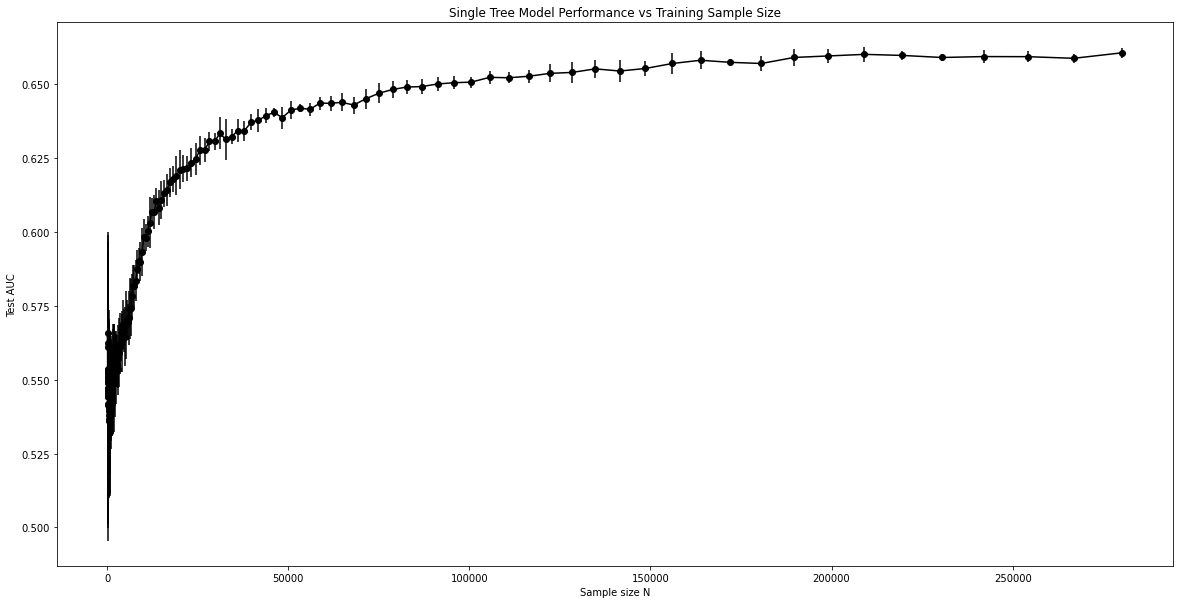

In [16]:
# Create plot
plt.figure()
# Set figure size
plt.figure(figsize=(20,10))
# plot the number of samples along with the corresponding performance and standard devaiation
plt.errorbar(x = table_results.index, y = table_results.Test_AUC_mean, yerr = table_results.Test_AUC_standard_deviation, fmt='o-', color='black')
# plot labeling
plt.title('Single Tree Model Performance vs Training Sample Size')
plt.xlabel('Sample size N')
plt.ylabel('Test AUC')

Plot the x log scaled version of the model performance vs training sample size error bar graph for better clearity of the data points with small sample size N.

Text(0, 0.5, 'Test AUC')

<Figure size 432x288 with 0 Axes>

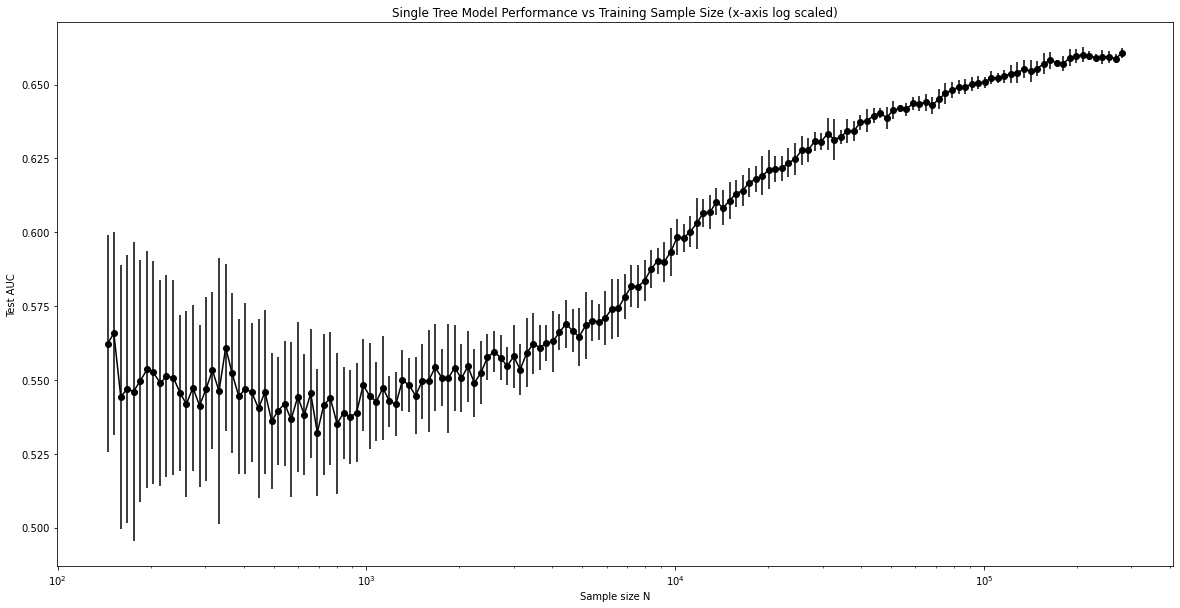

In [17]:
# Create plot
plt.figure()
# Set figure size
plt.figure(figsize=(20,10))
# log scale the x axis for a clearier representation
plt.xscale('log')
# plot the number of samples along with the corresponding performance and standard devaiation
plt.errorbar(x = table_results.index, y = table_results.Test_AUC_mean, yerr = table_results.Test_AUC_standard_deviation, fmt='o-', color='black')
# plot labeling
plt.title('Single Tree Model Performance vs Training Sample Size (x-axis log scaled)')
plt.xlabel('Sample size N')
plt.ylabel('Test AUC')

**From this plot, can you estimate what is the minimum number of samples needed to model the behaviour adequately?**

Yes, one can estimate the minimum number of samples needed to model to behavior adequately. The number of train data used to train the model is negatively correlated with the variance/standard deviation of the model performance. As the number of train data used to train the model increases, the variance/standard deviation of the model performance decreases. 

A behavior is well modeled, when the model test results are consistent regardless of the train data provided. There is a certain extent of the amount of information the data can provide about the underlying behavior. Once the training samples used to train the model can sufficiently cover the underlying behavior in the data, adding more training samples won't provide any useful additional information for the model to better classify unseen data.

To define if a behavior is modeled adequately, one could look at two factors: 1, if the variance/standard deviation converged/stabilized under a small acceptable pre-defined value and 2, if there is no obvious increase in model performance as the number of training samples increase.

From the business perspective there is always a trade-off between the cost of acquiring more data and the value in better performance. One should stop when the cost of acquiring more data out weights the gain from higher model performance. 

For this assignment I would select the sample size of around 100,000 training samples. This is because at this point the standard deviation of the model performance has converged, average model performance shows no obvious increase, and it requires an additional 180,000 samples to increase the average performance by another 1%.